# Random Forest on 80/20 Data Splitting Approach

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.preprocessing import LabelBinarizer
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

LOAD TRAINING AND TEST DATASETS

In [2]:
X = joblib.load('csv 20 minutes/labeled2/features_final/together/X1.pkl')
y = joblib.load('csv 20 minutes/labeled2/features_final/together/y1.pkl')
X_train = joblib.load('csv 20 minutes/labeled2/features_final/together/X_train1.pkl')
X_test = joblib.load('csv 20 minutes/labeled2/features_final/together/X_test1.pkl')
y_train = joblib.load('csv 20 minutes/labeled2/features_final/together/y_train1.pkl')
y_test = joblib.load('csv 20 minutes/labeled2/features_final/together/y_test1.pkl')

Train the model

In [4]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

SAVE THE MODEL

In [ ]:
joblib.dump(rf_classifier, 'csv 20 minutes/labeled2/features_final/together/random_forest_model1.pkl')

LOAD THE MODEL

In [3]:
rf_classifier = joblib.load('csv 20 minutes/labeled2/features_final/together/random_forest_model1.pkl')

# Evaluation

## Accuracy

In [5]:
y_pred = rf_classifier.predict(X_test)
train_pred = rf_classifier.predict(X_train)

accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, train_pred)
print("Test Accuracy:", accuracy)
print('Test Accuracy : ', metrics.accuracy_score(
    y_test, rf_classifier.predict(X_test))*100)
print("Training Accuracy:", accuracy_train)
print('Training Accuracy : ',
      metrics.accuracy_score(
          y_train, rf_classifier.predict(X_train))*100)

Test Accuracy: 0.9997171773187301
Test Accuracy :  99.97171773187301
Training Accuracy: 0.9999916816627802
Training Accuracy :  99.99916816627803


## ACCURACY OF EACH DEVICE TYPE

Need to preprocess the data again cause not able to open the file 'all_data_final' because of its size

In [8]:
load_final_csv = 'csv 20 minutes/labeled2/features_final/together/all_data_final_before_one_hot_encoded.csv'
data = pd.read_csv(load_final_csv, delimiter=';', encoding='ISO-8859-1')

In [10]:
def get_feature_types(df):
    numerical_features = []
    categorical_features = []
    boolean_features = []
    for column_name, column_type in df.dtypes.items():
        if column_type in ['int64', 'float64']:
            numerical_features.append(column_name)
        elif column_type == 'object':
            categorical_features.append(column_name)
        elif column_type == 'bool':
            boolean_features.append(column_name)
    return numerical_features, categorical_features, boolean_features

numerical_features, categorical_features, boolean_features = get_feature_types(data)

def one_hot_encode_features(data, categorical_features):
    if 'label' in categorical_features:
        categorical_features.remove('label')
    if 'subcategory' in categorical_features:
        categorical_features.remove('subcategory')
    data = pd.get_dummies(data, columns=categorical_features, drop_first=True)
    return data

data = one_hot_encode_features(data, categorical_features)
data.fillna(0, inplace=True)

Total number of rows: 901623
Rows with NaN values:


In [12]:
# Predict the labels
y_pred_test = rf_classifier.predict(X_test)
y_pred_train = rf_classifier.predict(X_train)

overall_accuracy_test = accuracy_score(y_test, y_pred_test)
overall_accuracy_train = accuracy_score(y_train, y_pred_train)
print("Overall Testing Accuracy:", overall_accuracy_test)
print("Overall Training Accuracy:", overall_accuracy_train)

# Calculate accuracy for each device type
unique_labels = data['label'].unique()
for label in unique_labels:
    mask = (y_test == label)
    accuracy = accuracy_score(y_test[mask], y_pred_test[mask])
    print("Accuracy for", label, ":", accuracy)

Overall Testing Accuracy: 0.9997171773187301
Overall Training Accuracy: 0.9999916816627802
Accuracy for Laptop : 0.9993709702783456
Accuracy for Headphone : 0.9999309678310092
Accuracy for iPad : 0.9995955510616784
Accuracy for Airtag : 0.9959664908470369
Accuracy for TV : 1.0
Accuracy for Kitchen : 0.9998699271592092
Accuracy for Smartwatch : 0.9996839158313013
Accuracy for Camera : 0.9999233363998773
Accuracy for Smartphone : 0.9998515953499877
Accuracy for Bathroom : 0.999961690227177


## PRECISION, RECALL, SPECIFICITY, F1-SCORE

In [5]:
y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

labels = sorted(set(y_test))
metrics = []

for i, label in enumerate(labels):
    tn = conf_matrix.sum() - (conf_matrix[:, i].sum() + conf_matrix[i, :].sum() - conf_matrix[i, i])
    tp = conf_matrix[i, i]
    fn = conf_matrix[i, :].sum() - tp
    fp = conf_matrix[:, i].sum() - tp
    
    precision = report[str(label)]['precision']
    recall = report[str(label)]['recall']
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = report[str(label)]['f1-score']
    
    metrics.append({
        'label': label,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1-score': f1,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    })
print(pd.DataFrame(metrics))

        label  precision    recall  specificity  f1-score     tp  fp      tn  \
0      Airtag   0.996585  0.995966     0.999938  0.996276   3210  11  177091   
1    Bathroom   1.000000  0.999962     1.000000  0.999981  26102   0  154222   
2      Camera   1.000000  0.999923     1.000000  0.999962  26086   0  154237   
3   Headphone   0.999965  0.999931     0.999993  0.999948  28970   1  151352   
4     Kitchen   1.000000  0.999870     1.000000  0.999935   7687   0  172637   
5      Laptop   0.999646  0.999371     0.999942  0.999509  25420   9  154880   
6  Smartphone   1.000000  0.999852     1.000000  0.999926  20212   0  160110   
7  Smartwatch   0.999278  0.999684     0.999899  0.999481  22139  16  158163   
8          TV   1.000000  1.000000     1.000000  1.000000   5619   0  174706   
9        iPad   0.999057  0.999596     0.999915  0.999326  14829  14  165476   

   fn  
0  13  
1   1  
2   2  
3   2  
4   1  
5  16  
6   3  
7   7  
8   0  
9   6  


## CONFUSION MATRIX

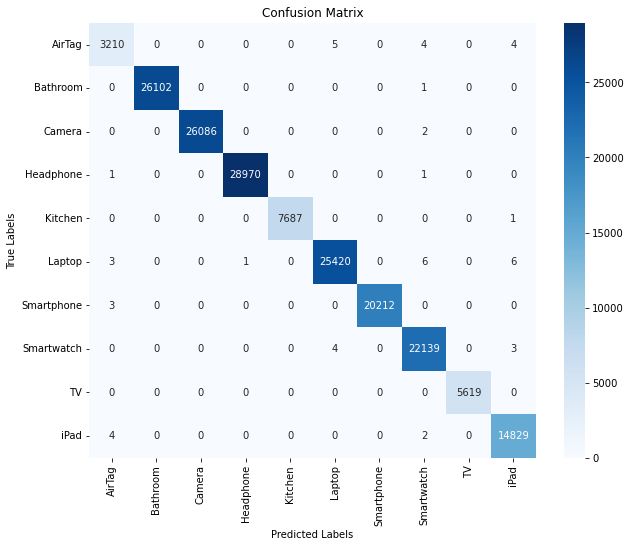

In [8]:
def replace_airtag(label):
    if label == 'Airtag':
        return 'AirTag'
    else:
        return label
class_labels_modified = [replace_airtag(label) for label in rf_classifier.classes_]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_modified, yticklabels=class_labels_modified)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('Classification/Confusion Matrix RF1.png', bbox_inches='tight')
plt.show()

## CHECK OVERFITTING & CROSS VALIDATION

Training Accuracy: 0.9999916816627802
Testing Accuracy: 0.9997171773187301
Cross-validation scores: [0.85721336 0.98913628 0.86761126 0.99332868 0.87166434]
Mean CV accuracy: 0.9157907833001664


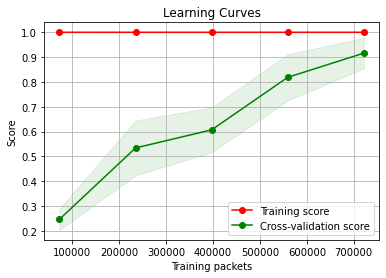

In [10]:
# compare training and test accuracies to check overfitting
train_accuracy = accuracy_score(y_train, rf_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, rf_classifier.predict(X_test))
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(rf_classifier, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training packets")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.savefig('Classification/Overfitting Check RF1.png', bbox_inches='tight')
plt.show()